In [7]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime

In [265]:
# url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt'
df = pd.read_csv('combined_csv.csv', header = 0, sep=',')
df.columns = map(str.lower, df.columns) # - make headers lowercase
df.columns = df.columns.str.strip().str.lower()



TypeError: sort_values() got an unexpected keyword argument 'sort'

In [269]:
df['ttime'] = pd.to_datetime(df['time'])
df['tdate'] = pd.to_datetime(df['date'])
df['datetime'] = df.apply (lambda x: datetime.datetime (x['tdate'].year, x['tdate'].month, x['tdate'].day,
                                                       x['ttime'].hour), axis=1)
df.drop (['ttime','tdate'], inplace=True, axis=1)
df['exit_increments'] = df['exits']
df['entry_increments'] = df['entries']
df['previous_entry_number'] = df['entries']
df['time_block'] = df['entries']
df['previous_datetime'] = df['datetime']

# -- add day of week column value
df['weekday'] = df['datetime'].dt.weekday_name



In [271]:
#This creates the dataframe that will be used to store entries for a given station/control area pair for hours
#of the day
tuple1 = ('59 ST', 'A002', 1)

#Convert a tuple into a string for indexing purposes. This is an unfortunate kludge that was necessary due to having
#trouble using a tuple as an index
def string_from_tuple (tup):
    return tup[0]+','+tup[1]+','+str(tup[2])

summary_data = pd.DataFrame(
    data={'c_a_station_time_block': [tuple1],
          'c_a_station': [('59 ST', 'A002')],
          'time_block': [1],
          'entries': [0]},
    index=[string_from_tuple (tuple1)],
    columns=['c_a_station_time_block', 'c_a_station', 'time_block', 'entries'])

#Tabulate the number of entries over a particular four hour block at a particular station/control area pair
def tabulate_entries (ix, data_frame):
    station = data_frame.at [ix, 'station']
    control_area = data_frame.at [ix, 'c/a']
    time_block = data_frame.at [ix, 'time_block']
    entries = data_frame.at [ix, 'entry_increments']
    c_a_station = (station, control_area)
    c_a_station_time_block = (station, control_area, time_block)
    summary_index = string_from_tuple (c_a_station_time_block)
    try:
        existing_entries = summary_data.at [summary_index, 'entries']
        summary_data.at [summary_index, 'entries'] = entries + existing_entries
    except KeyError:
        summary_data.loc [summary_index] = [c_a_station_time_block, c_a_station, time_block, entries]

#Converts a datetime to an integer code representing the four hour block in the week, because
#MTA generally uses four hour intervals. 12am-2am Saturday = 0, 2am-6am Saturday = 1, and so on up to
#6pm-10pm Friday = 41, 10pm-midnight Friday = 42
def convert_datetime_to_four_hour_block (dt):
    day_of_week = dt.weekday()
    day_of_week += 2
    if day_of_week >= 7:
        day_of_week -= 7
    hour = round((dt.hour+.01)/4)
    result = int((6*day_of_week) + hour)
    return result

def max_minus_min_exits (x):
    first_iteration = True
    previous_exits = 0
    for index, row in x.iteritems():
        if first_iteration:
            first_iteration = False
            previous_exits = row
            df.at [index, 'exit_increments'] = -1
        else:
            df.at [index, 'exit_increments'] = row - previous_exits
            previous_exits = row
    result = x.max()-x.min()
    return result
    
def max_minus_min_entries (x):
    first_iteration = True
    previous_entries = 0
    previous_datetime = datetime.datetime (1980,1,1)
    for index, row in x.iteritems():
        if first_iteration:
            first_iteration = False
            previous_entries = row
            df.at [index, 'previous_datetime'] = previous_datetime
            previous_datetime = df.at [index, 'datetime']
            df.at [index, 'entry_increments'] = -1
            df.at [index, 'previous_entry_number'] = -1
            df.at [index, 'time_block'] = -1
        else:
            df.at [index, 'previous_datetime'] = previous_datetime
            previous_datetime = df.at [index, 'datetime']
            entry_count = row - previous_entries
            df.at [index, 'entry_increments'] = entry_count
            df.at [index, 'previous_entry_number'] = previous_entries
            df.at [index, 'time_block'] = convert_datetime_to_four_hour_block (previous_datetime)
            if (entry_count >0) and (entry_count < 5000):
                tabulate_entries (index, df)
            previous_entries = row
    result = x.max()-x.min()
    return result
    
dfgb_exit_group = df.groupby (['station', 'c/a', 'unit', 'scp']) ['exits'].apply (max_minus_min_exits)
dfgb_entry_group = df.groupby (['station', 'c/a', 'unit', 'scp']) ['entries'].apply (max_minus_min_entries)
dfgb2 = dfgb_exit_group.groupby ('station')
dfgb3 = dfgb2.apply (lambda x:x.sum())
dfgb4 = dfgb3.sort_values (0, False)
#print (dfgb4)
#print (dfgb4.sum())
#print(len(dfgb4))
dfgb4.tail(360).sum()
dfgb=dfgb_exit_group.sort_values (0, False)
print (dfgb.sum())
print (len(dfgb))
print (dfgb)
dfgb.tail(4875).sum()

115017392162
5078
station          c/a    unit  scp     
BOWLING GREEN    R201   R041  00-00-00    2145109813
61 ST WOODSIDE   R523   R147  00-00-04    2109217297
34 ST-HERALD SQ  A025   R023  01-03-02    2049820042
                 N506   R022  00-05-04    2040660172
7 AV             N539   R288  00-03-01    2029873651
ELMHURST AV      N325A  R218  00-05-01    1973057511
                              00-06-01    1944187710
28 ST            R228   R143  00-00-01    1880724421
182-183 STS      N215   R237  00-00-02    1838639204
190 ST           N006A  R280  00-00-00    1836415849
167 ST           N207   R104  00-00-00    1822490320
GRANT AV         N129   R382  00-00-00    1756077063
72 ST            R161B  R452  00-00-03    1752573369
EASTCHSTER/DYRE  R730   R431  00-00-04    1727140260
LEXINGTON AV/53  N305   R017  01-00-04    1706222667
103 ST           R252   R180  00-03-02    1685988123
116 ST           N029   R333  01-00-02    1626520779
CHURCH AV        R639   R109  00-06-00    

5121727394

In [272]:
sort_mask = (df['entry_increments'] > -1) & (df['exit_increments'] > -1
                                             ) &(df['entry_increments'] < 5000
                                                ) & (df['exit_increments'] < 5000)


df = df[sort_mask]
df.head()

# - this is a deep div into the hourly incrementation per terminal

# entry increments -- the number of entries in the current 4 hour period 
#-----at the beginning at previous datetime and ending at datetime
# exit increments -- the number of exits in the 4 hour period starting at
# -----the beginnning of the previous datetime and ending at datetime
# time_block -- represents what 4 hour period the datetime is in during 
# ---- period week. number of 4 hour periods that 
# -----have elapsed since saturday midnight
# 


,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,exit_increments,entry_increments,previous_entry_number,time_block,previous_datetime,weekday
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,04:00:00,REGULAR,6566470,2224053,2018-03-31 04:00:00,3,7,6566463,1,2018-03-31 00:00:00,Saturday
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,08:00:00,REGULAR,6566470,2224053,2018-03-31 08:00:00,0,0,6566470,2,2018-03-31 04:00:00,Saturday
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,12:00:00,REGULAR,6566470,2224055,2018-03-31 12:00:00,2,0,6566470,3,2018-03-31 08:00:00,Saturday
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,16:00:00,REGULAR,6566470,2224055,2018-03-31 16:00:00,0,0,6566470,4,2018-03-31 12:00:00,Saturday
5,5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,20:00:00,REGULAR,6566470,2224055,2018-03-31 20:00:00,0,0,6566470,5,2018-03-31 16:00:00,Saturday


In [46]:
# - entries by station by day

station_day_groupby = df.groupby(["date", 'station','weekday']
                                )['entry_increments', 'exit_increments'
                                 ].sum().reset_index().sort_values('entry_increments', ascending=False)
station_day_groupby.head()


,date,station,weekday,entry_increments,exit_increments
1950,06/13/2019,34 ST-PENN STA,Thursday,182825,158274
1195,06/11/2019,34 ST-PENN STA,Tuesday,177588,152787
1573,06/12/2019,34 ST-PENN STA,Wednesday,177136,158956
817,06/10/2019,34 ST-PENN STA,Monday,170136,146196
2120,06/13/2019,GRD CNTRL-42 ST,Thursday,167009,142257


In [273]:
# - entries and exits correlatie with time of day
# - entries and exits with weekday
# - which stations have the hightest entries and exits per weekday

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


In [274]:
#

station_groupby = df.groupby(['station', 'time_block']
                                )['entry_increments', 'exit_increments'
                                 ].sum().reset_index()

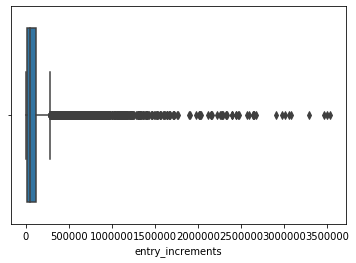

In [275]:
# - box plot to find outliers

sns.boxplot(x=station_groupby['entry_increments'])

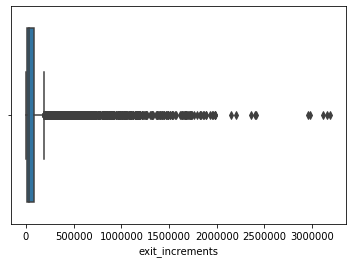

In [276]:
# - box plot to find outliers exits

sns.boxplot(x=station_groupby['exit_increments'])

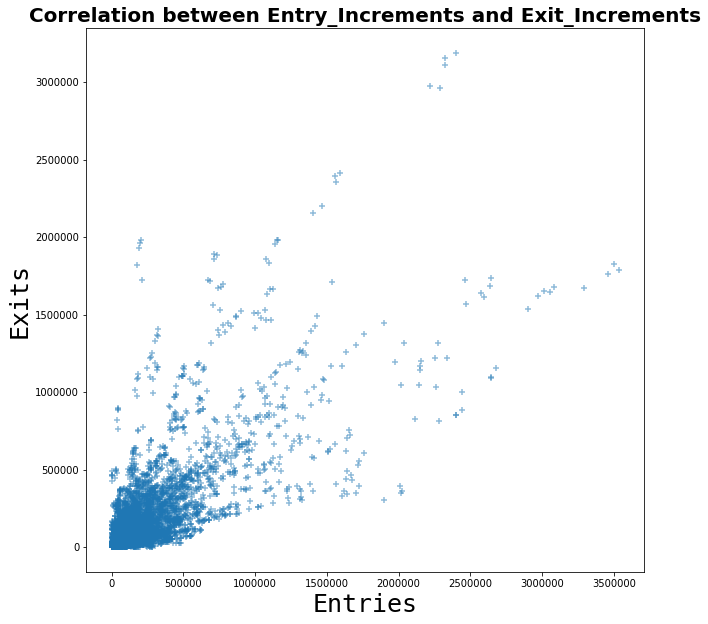

In [277]:
# - entries correlated with exits


# correlations = station_groupby.corr()
plt.figure(figsize=[10,10])
plt.scatter(station_groupby['entry_increments']
            , station_groupby['exit_increments']
            ,marker = '+'
           , alpha = 0.5)
plt.title('Correlation between Entry_Increments and Exit_Increments', fontsize=20, weight = 'bold')
plt.xlabel("Entries", fontsize = '25', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '25', family = 'monospace',color='black');


plt.show();



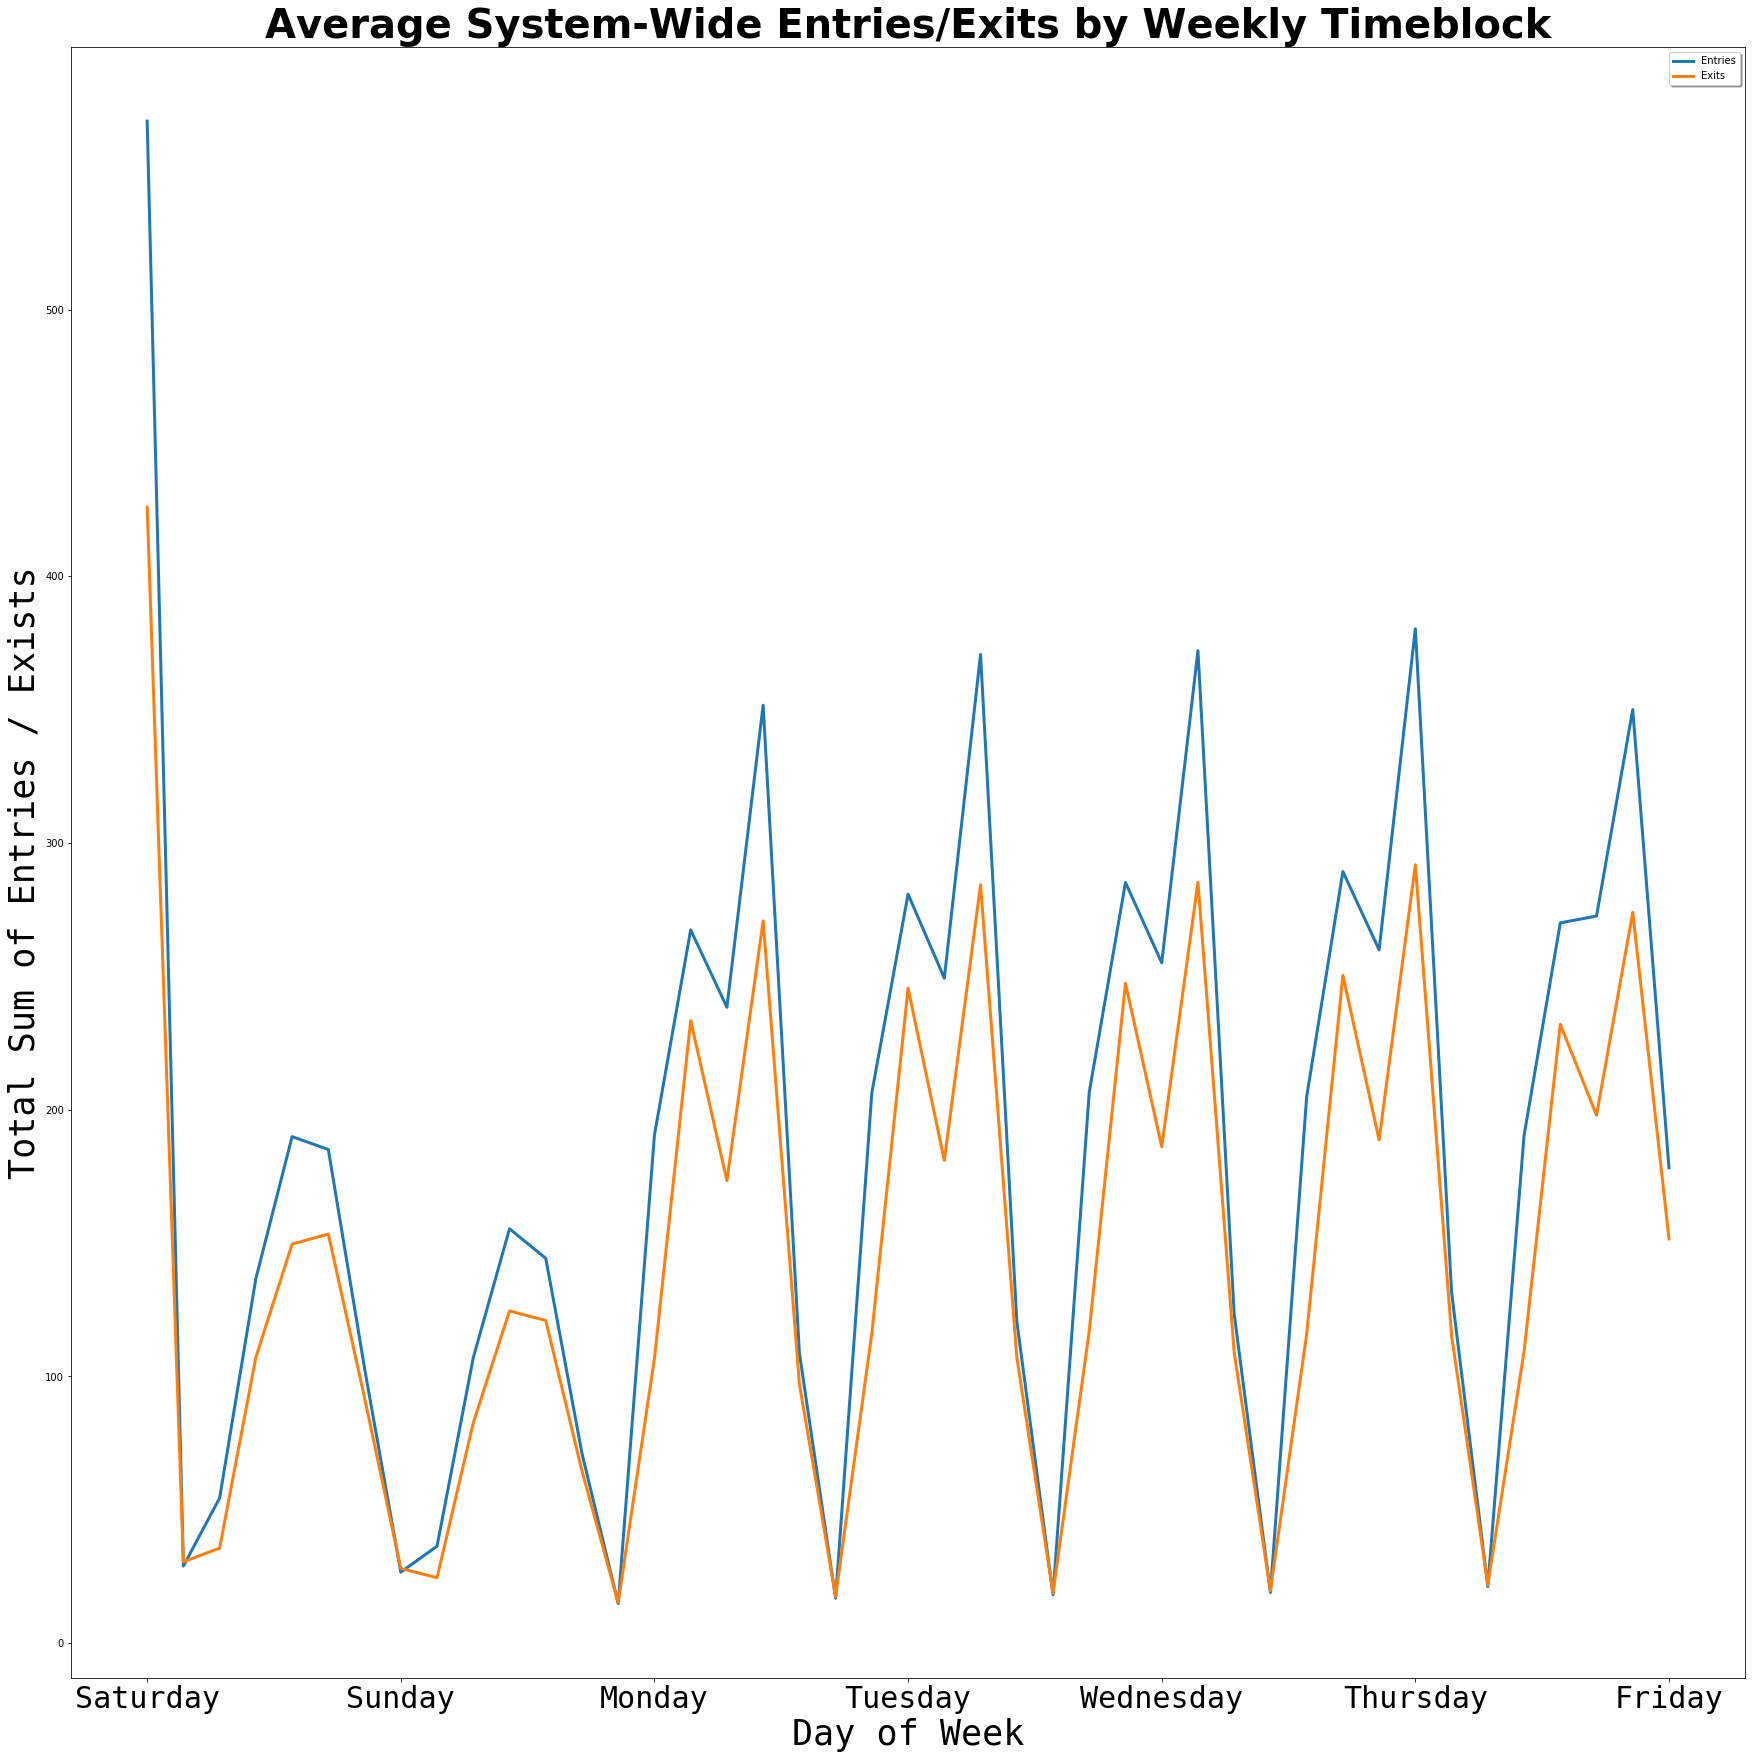

In [284]:
weekday_groupby = df.groupby(['time_block'])['entry_increments','exit_increments'].mean().reset_index()
plt.figure(figsize = [30, 30])
plt.plot(weekday_groupby['time_block'],weekday_groupby['entry_increments'], linewidth=3)
plt.plot(weekday_groupby['time_block'],weekday_groupby['exit_increments'], linewidth=3)
plt.title('Average System-Wide Entries/Exits by Weekly Timeblock', fontsize=40, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '30', family = 'monospace',color='black')
plt.xlabel("Day of Week", fontsize = '35', family = 'monospace',color='black');
plt.ylabel("Total Sum of Entries / Exists ", fontsize = '35', family = 'monospace',color='black');
plt.legend(['Entries','Exits'],shadow = True, loc = 0);
plt.savefig('average_entries_exits.png')

In [289]:
#top 6 control areas
#grid plots of entries and exits by day


# - find top stations over the week
topstations_groupby = df.groupby(['station','time_block'])['entry_increments','exit_increments'].sum().sort_values('entry_increments',ascending = False).reset_index()
topstations_groupby.head(6)

top_stations =topstations_groupby.groupby(['station'])['entry_increments','exit_increments'].sum().sort_values('entry_increments',ascending = False).reset_index()

top_stations.head(6)


,station,entry_increments,exit_increments
0,34 ST-PENN STA,52920260,46216711
1,GRD CNTRL-42 ST,45772409,41039145
2,34 ST-HERALD SQ,36660877,34200669
3,23 ST,36075494,26262058
4,14 ST-UNION SQ,33964350,30230137
5,TIMES SQ-42 ST,31837744,29991394


In [151]:
# - create masks for top stations

penn_mask = (topstations_groupby['station'] == '34 ST-PENN STA')
penn_df = topstations_groupby[penn_mask]

grand_mask = (topstations_groupby['station'] == 'GRD CNTRL-42 ST')
grand_df = topstations_groupby[grand_mask]

herald_mask = (topstations_groupby['station'] == '34 ST-HERALD SQ')
herald_df = topstations_groupby[herald_mask]

twentythird_mask = (topstations_groupby['station'] == '23 ST')
twentythird_df = topstations_groupby[twentythird_mask]

union_mask = (topstations_groupby['station'] == '14 ST-UNION SQ')
union_df = topstations_groupby[union_mask]

times_mask = (topstations_groupby['station'] == 'TIMES SQ-42 ST')
times_df = topstations_groupby[times_mask]


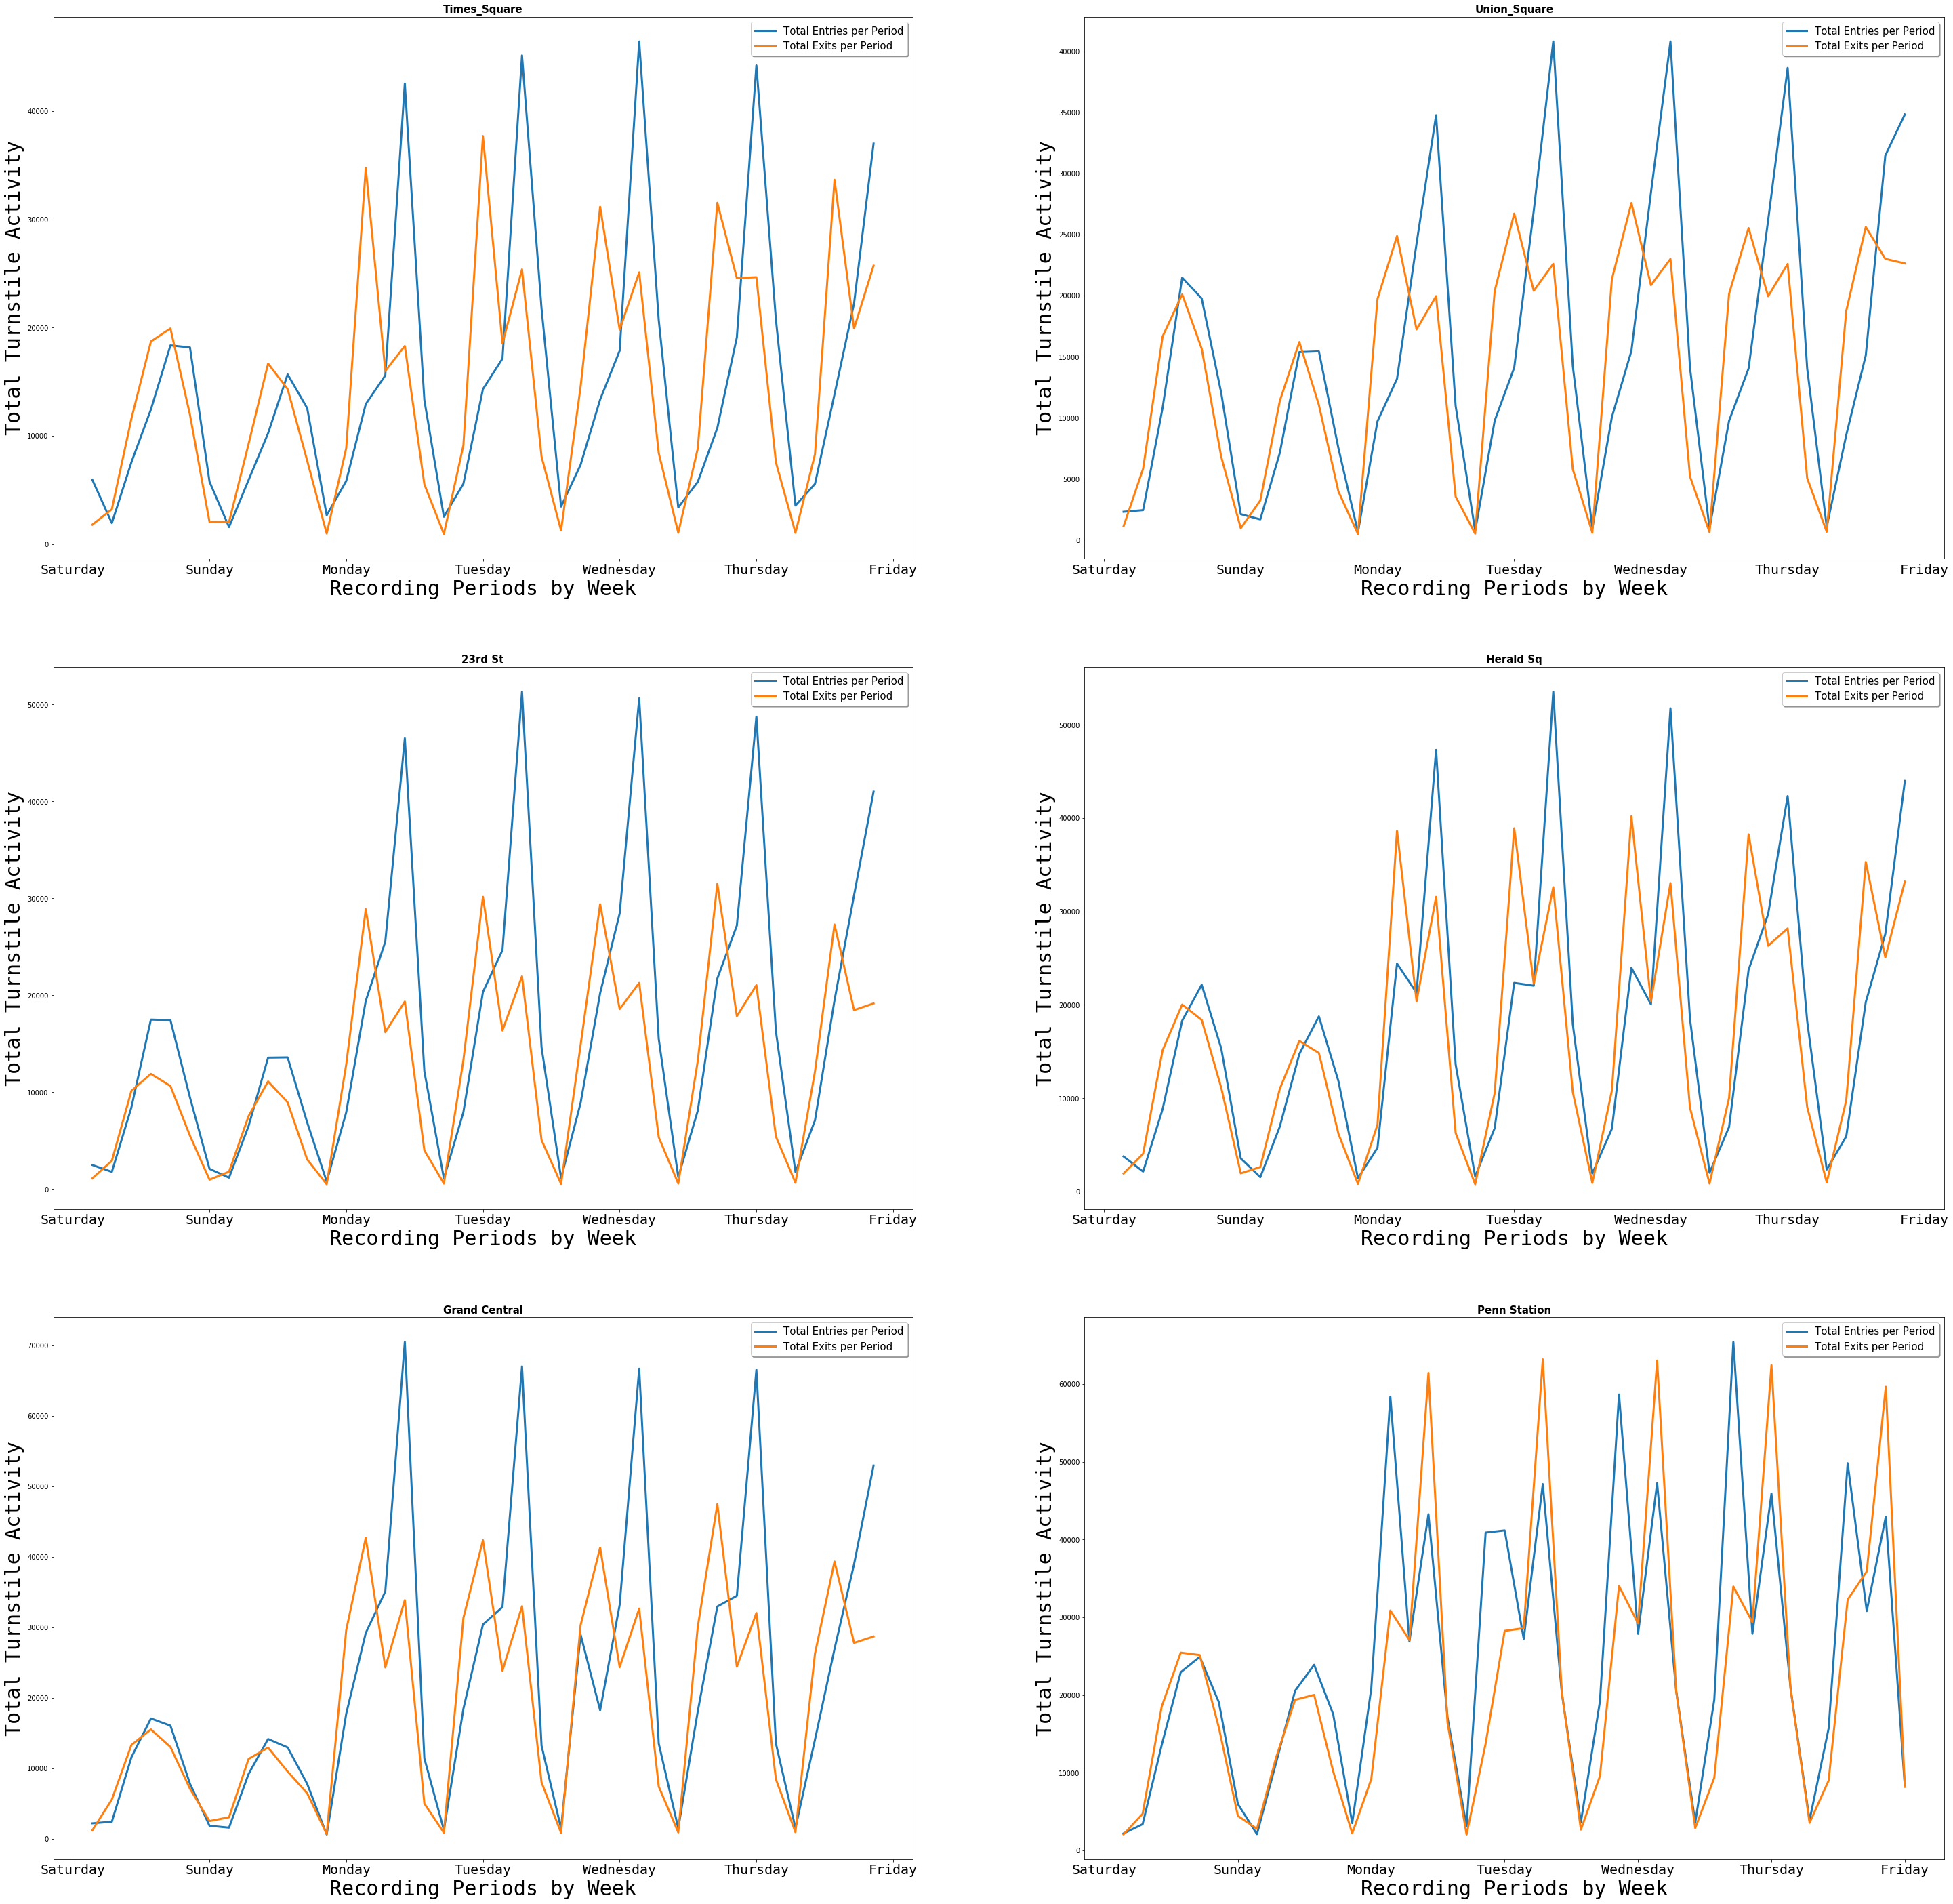

In [294]:
fig.set_figwidth(10)
fig.set_figheight(6)
fig.suptitle('Top 6 Performing Stations',fontsize = 16)


plt.figure(figsize = [50, 50])


plt.subplot(3,2,1)
plt.plot(times_df['time_block'],times_df['entry_increments'],linewidth=3)
plt.plot(times_df['time_block'],times_df['exit_increments'], linewidth=3)
plt.title('Times_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '20', family = 'monospace',color='black')
plt.xlabel("Recording Periods by Week", fontsize = '30', family = 'monospace',color='black');
plt.ylabel("Total Turnstile Activity", fontsize = '30', family = 'monospace',color='black')
plt.legend(['Total Entries per Period','Total Exits per Period'],shadow = True, loc = 0, prop={'size': 15})



plt.subplot(3,2,2)
plt.plot(union_df['time_block'],union_df['entry_increments'],linewidth=3)
plt.plot(union_df['time_block'],union_df['exit_increments'],linewidth=3)
plt.title('Union_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '20', family = 'monospace',color='black')
plt.xlabel("Recording Periods by Week", fontsize = '30', family = 'monospace',color='black');
plt.ylabel("Total Turnstile Activity", fontsize = '30', family = 'monospace',color='black')
plt.legend(['Total Entries per Period','Total Exits per Period'],shadow = True, loc = 0, prop={'size': 15})


plt.subplot(3,2,3)
plt.plot(twentythird_df['time_block'],twentythird_df['entry_increments'],linewidth=3)
plt.plot(twentythird_df['time_block'],twentythird_df['exit_increments'],linewidth=3)
plt.title('23rd St', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '20', family = 'monospace',color='black')
plt.xlabel("Recording Periods by Week", fontsize = '30', family = 'monospace',color='black');
plt.ylabel("Total Turnstile Activity", fontsize = '30', family = 'monospace',color='black')
plt.legend(['Total Entries per Period','Total Exits per Period'],shadow = True, loc = 0, prop={'size': 15})



plt.subplot(3,2,4)
plt.plot(herald_df['time_block'],herald_df['entry_increments'],linewidth=3)
plt.plot(herald_df['time_block'],herald_df['exit_increments'],linewidth=3)
plt.title('Herald Sq', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '20', family = 'monospace',color='black')
plt.xlabel("Recording Periods by Week", fontsize = '30', family = 'monospace',color='black');
plt.ylabel("Total Turnstile Activity", fontsize = '30', family = 'monospace',color='black')
plt.legend(['Total Entries per Period','Total Exits per Period'],shadow = True, loc = 0, prop={'size': 15})



plt.subplot(3,2,5)
plt.plot(grand_df['time_block'],grand_df['entry_increments'],linewidth=3)
plt.plot(grand_df['time_block'],grand_df['exit_increments'],linewidth=3)
plt.title('Grand Central', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '20', family = 'monospace',color='black')
plt.xlabel("Recording Periods by Week", fontsize = '30', family = 'monospace',color='black');
plt.ylabel("Total Turnstile Activity", fontsize = '30', family = 'monospace',color='black')
plt.legend(['Total Entries per Period','Total Exits per Period'],shadow = True, loc = 0, prop={'size': 15})


plt.subplot(3,2,6)
plt.plot(penn_df['time_block'],penn_df['entry_increments'],linewidth=3)
plt.plot(penn_df['time_block'],penn_df['exit_increments'],linewidth=3)
plt.title('Penn Station', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '20', family = 'monospace',color='black')
plt.xlabel("Recording Periods by Week", fontsize = '30', family = 'monospace',color='black');
plt.ylabel("Total Turnstile Activity", fontsize = '30', family = 'monospace',color='black')
plt.legend(['Total Entries per Period','Total Exits per Period'],shadow = True, loc = 0, prop={'size': 15})


plt.savefig('top_traffic_stations.png')

In [166]:
df


,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,exit_increments,entry_increments,previous_entry_number,time_block,previous_datetime,weekday
52136,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/10/2019,20:00:00,REGULAR,1421485,5605831,2019-06-10 20:00:00,4753,85,1421400,17,2019-06-10 16:00:00,Monday
52142,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/11/2019,20:00:00,REGULAR,1423900,5616013,2019-06-11 20:00:00,4465,102,1423798,23,2019-06-11 16:00:00,Tuesday
52150,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/12/2019,20:00:00,REGULAR,1426088,5626830,2019-06-12 20:00:00,4303,97,1425991,29,2019-06-12 16:00:00,Wednesday
159673,R240,R047,00-00-00,GRD CNTRL-42 ST,4567S,IRT,06/13/2019,13:00:00,REGULAR,5315468,13039820,2019-06-13 13:00:00,4264,182,5315286,33,2019-06-13 09:00:00,Thursday
52180,N063A,R011,00-00-01,42 ST-PORT AUTH,ACENQRS1237W,IND,06/10/2019,20:00:00,REGULAR,1280095129,176305697,2019-06-10 20:00:00,4238,139,1280094990,17,2019-06-10 16:00:00,Monday
125514,PTH21,R540,01-00-00,PATH WTC 2,1,PTH,06/12/2019,10:38:20,REGULAR,6505,39226,2019-06-12 10:00:00,4175,99,6406,27,2019-06-12 06:00:00,Wednesday
52156,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/13/2019,20:00:00,REGULAR,1428907,5636897,2019-06-13 20:00:00,4170,98,1428809,35,2019-06-13 16:00:00,Thursday
159667,R240,R047,00-00-00,GRD CNTRL-42 ST,4567S,IRT,06/12/2019,13:00:00,REGULAR,5312404,13026568,2019-06-12 13:00:00,4078,268,5312136,27,2019-06-12 09:00:00,Wednesday
159661,R240,R047,00-00-00,GRD CNTRL-42 ST,4567S,IRT,06/11/2019,13:00:00,REGULAR,5309329,13014564,2019-06-11 13:00:00,3934,223,5309106,21,2019-06-11 09:00:00,Tuesday
125508,PTH21,R540,01-00-00,PATH WTC 2,1,PTH,06/11/2019,09:26:20,REGULAR,5217,30373,2019-06-11 09:00:00,3920,67,5150,20,2019-06-11 05:00:00,Tuesday


In [296]:
# - groupby time, mean entries exits

weekday_mask = (df['weekday'] != 'Saturday') & (df['weekday'] != 'Sunday')


weekday_df = df[weekday_mask]

hourly_groupby = weekday_df.groupby(['station','time'])['entry_increments','exit_increments'].mean().sort_values('time',ascending = True).reset_index()
# hourly_groupby.head(6)


weekday_stations_top_6 = weekday_df.groupby('station')['entry_increments','exit_increments'].sum().sort_values('entry_increments',ascending = False).reset_index()
weekday_stations_top_6.head(6)




,station,entry_increments,exit_increments
0,34 ST-PENN STA,44826311,38606567
1,GRD CNTRL-42 ST,40735333,36056208
2,23 ST,31149055,22449643
3,34 ST-HERALD SQ,30755874,28471497
4,14 ST-UNION SQ,27620527,24203752
5,FULTON ST,26290997,21997098


In [303]:

weekend_mask = (df['weekday'] == 'Saturday') | (df['weekday'] == 'Sunday')
weekend_df = df[weekend_mask]

# weekend_df.head()

hourly_groupby_weekend = weekend_df.groupby(['station','time'])['entry_increments','exit_increments'].mean().sort_values('time',ascending = True).reset_index()
hourly_groupby_weekend.head(6)


weekend_stations_top_6 = weekend_df.groupby('station')['entry_increments','exit_increments'].sum().sort_values('entry_increments',ascending = False).reset_index()
weekend_stations_top_6.head(6)

,station,entry_increments,exit_increments
0,34 ST-PENN STA,8093949,7610144
1,14 ST-UNION SQ,6343823,6026385
2,34 ST-HERALD SQ,5905003,5729172
3,TIMES SQ-42 ST,5615715,5763503
4,42 ST-PORT AUTH,5492261,4845384
5,GRD CNTRL-42 ST,5037076,4982937


In [297]:
# - mean entries and exits by time of day 

penn_hourly_mask = (hourly_groupby['station'] == '34 ST-PENN STA')
penn_hourly_df = hourly_groupby[penn_hourly_mask]

grand_hourly_mask = (hourly_groupby['station'] == 'GRD CNTRL-42 ST')
grand_hourly_df = hourly_groupby[grand_hourly_mask]

herald_hourly_mask = (hourly_groupby['station'] == '34 ST-HERALD SQ')
herald_hourly_df = hourly_groupby[herald_hourly_mask]

twentythird_hourly_mask = (hourly_groupby['station'] == '23 ST')
twentythird_hourly_df = hourly_groupby[twentythird_hourly_mask]

union_hourly_mask = (hourly_groupby['station'] == '14 ST-UNION SQ')
union_hourly_df = hourly_groupby[union_hourly_mask]

times_hourly_mask = (hourly_groupby['station'] == 'TIMES SQ-42 ST')
times_hourly_df = hourly_groupby[times_hourly_mask]

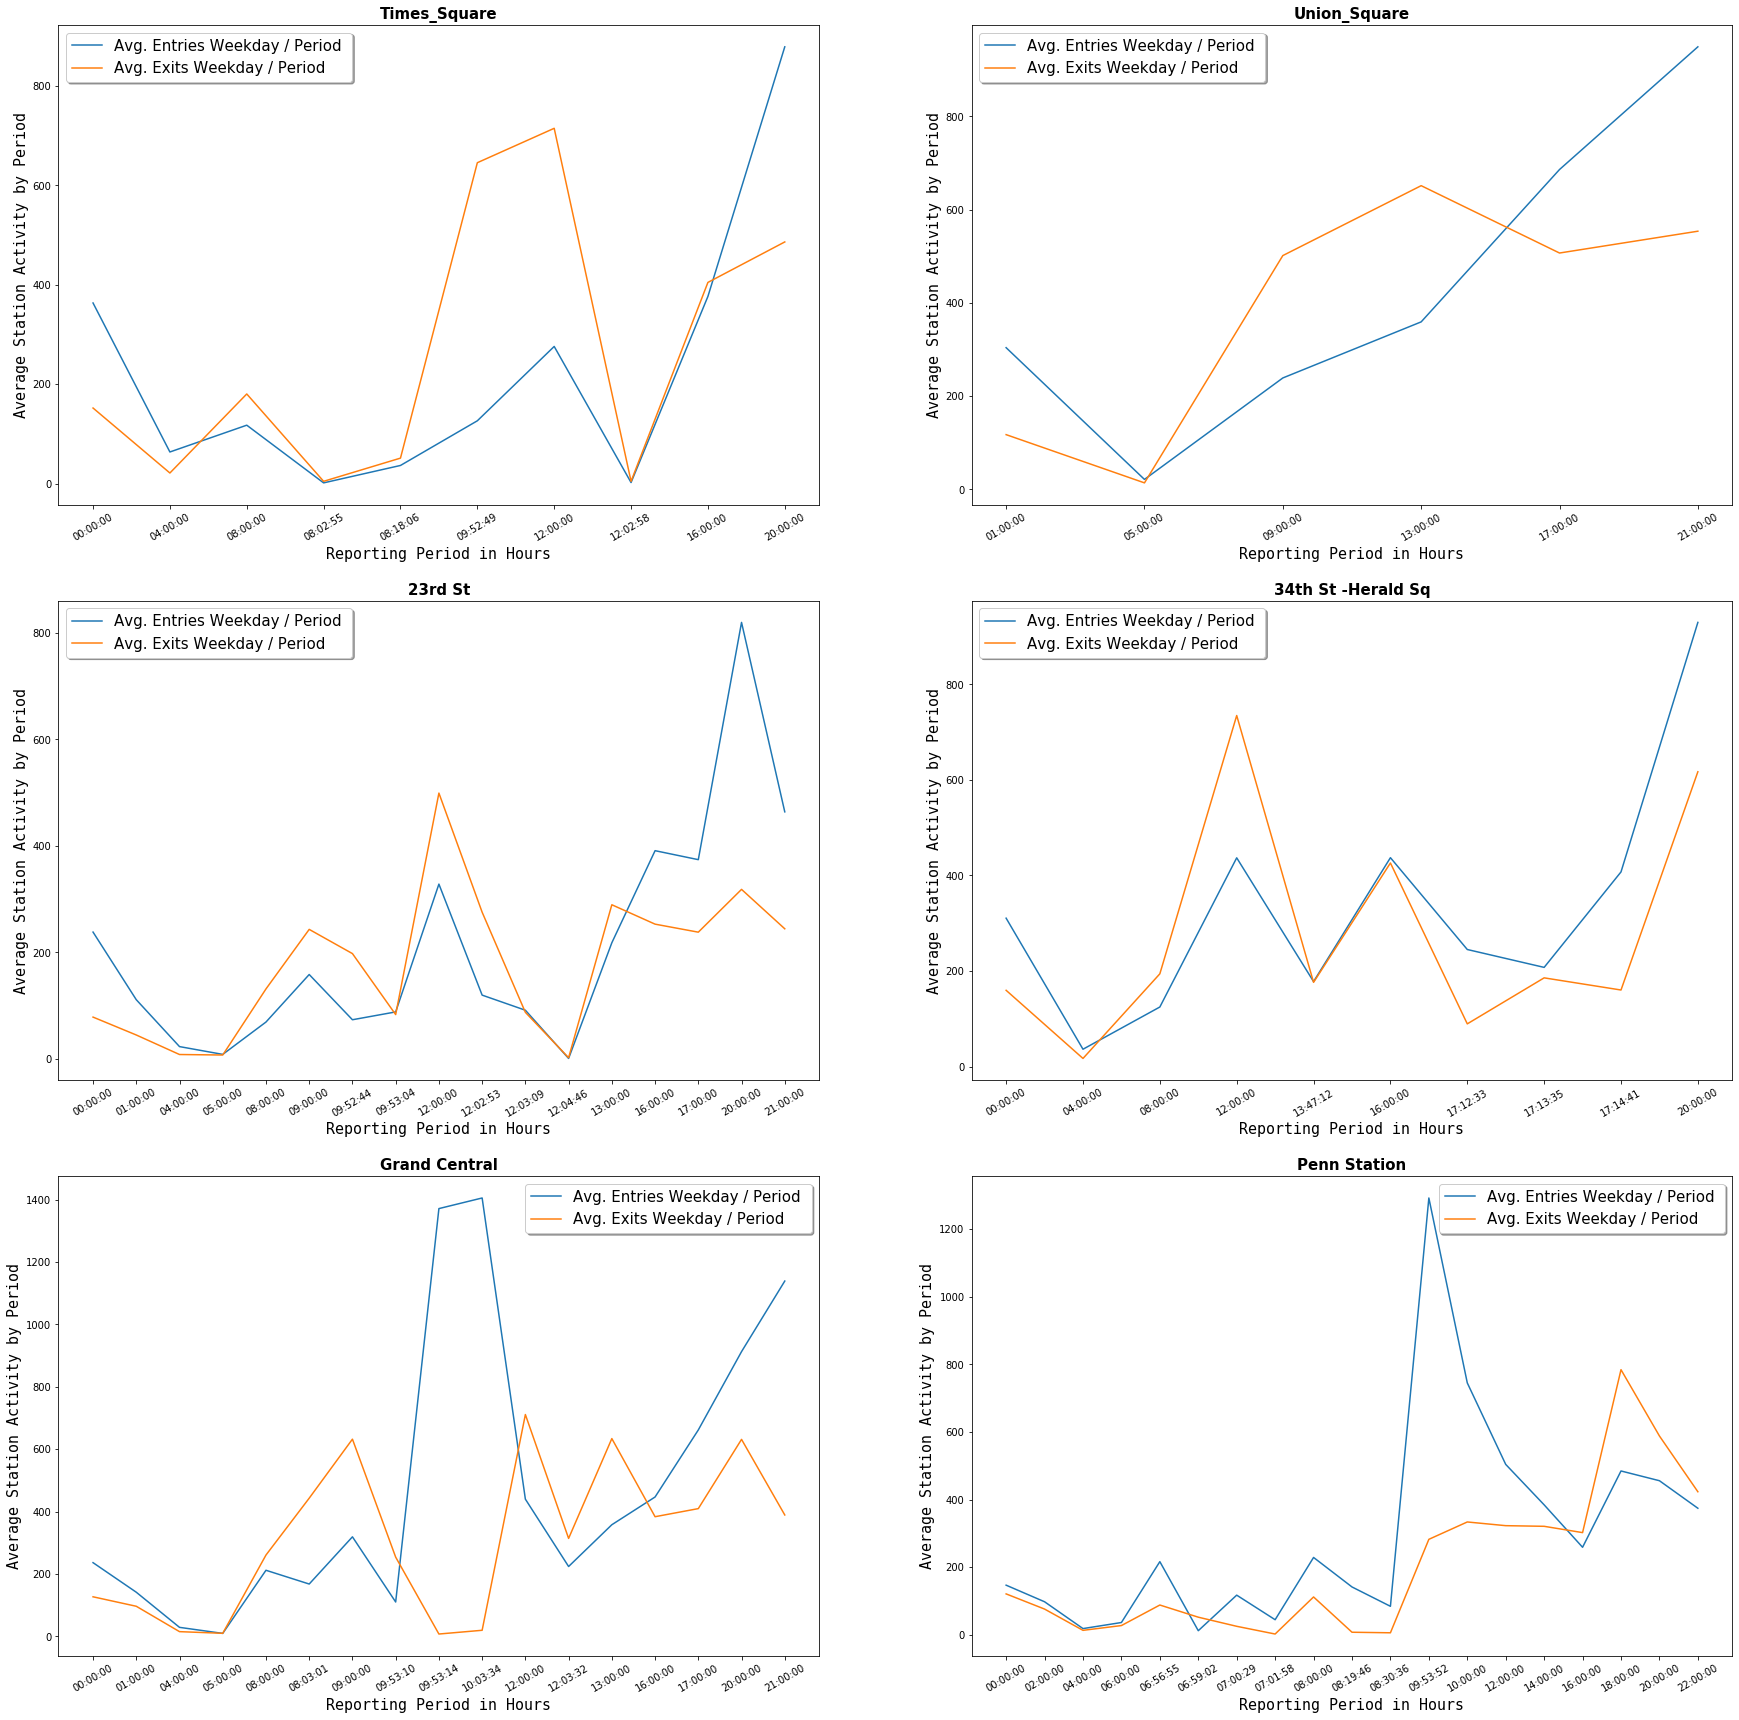

In [256]:
fig.set_figwidth(10)
fig.set_figheight(6)


plt.figure(figsize = [50, 50])

fig.suptitle('Top 6 Performing Station - Weekday',fontsize = 16)

plt.subplot(3,2,1)
plt.plot(times_hourly_df['time'],times_hourly_df['entry_increments'])
plt.plot(times_hourly_df['time'],times_hourly_df['exit_increments'])
plt.title('Weekday Station Activity by Hour, Times_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekday / Period ','Avg. Exits Weekday / Period '],shadow = True, loc = 0, prop={'size': 15})


plt.subplot(3,2,2)
plt.plot(union_hourly_df['time'],union_hourly_df['entry_increments'])
plt.plot(union_hourly_df['time'],union_hourly_df['exit_increments'])
plt.title('Weekday Station Activity by Hour, Union_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekday / Period ','Avg. Exits Weekday / Period '],shadow = True, loc = 0, prop={'size': 15})

plt.subplot(3,2,3)
plt.plot(twentythird_hourly_df['time'],twentythird_hourly_df['entry_increments'])
plt.plot(twentythird_hourly_df['time'],twentythird_hourly_df['exit_increments'])
plt.title('Weekday Station Activity by Hour, 23rd St', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekday / Period ','Avg. Exits Weekday / Period '],shadow = True, loc = 0, prop={'size': 15})


plt.subplot(3,2,4)
plt.plot(herald_hourly_df['time'],herald_hourly_df['entry_increments'])
plt.plot(herald_hourly_df['time'],herald_hourly_df['exit_increments'])
plt.title('Weekday Station Activity by Hour, 34th St -Herald Sq', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekday / Period ','Avg. Exits Weekday / Period '],shadow = True, loc = 0, prop={'size': 15})


plt.subplot(3,2,5)
plt.plot(grand_hourly_df['time'],grand_hourly_df['entry_increments'])
plt.plot(grand_hourly_df['time'],grand_hourly_df['exit_increments'])
plt.title('Weekday Station Activity by Hour, Grand Central', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekday / Period ','Avg. Exits Weekday / Period '],shadow = True, loc = 0, prop={'size': 15})

plt.subplot(3,2,6)
plt.plot(penn_hourly_df['time'],penn_hourly_df['entry_increments'])
plt.plot(penn_hourly_df['time'],penn_hourly_df['exit_increments'])
plt.title('Weekday Station Activity by Hour, Penn Station', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekday / Period ','Avg. Exits Weekday / Period '],shadow = True, loc = 0, prop={'size': 15})

plt.savefig('top_stations_by_hour_weeekday.png');

In [305]:
penn_hourly_mask_weekend = (hourly_groupby_weekend['station'] == '34 ST-PENN STA')
penn_hourly_df_weekend = hourly_groupby_weekend[penn_hourly_mask_weekend]

grand_hourly_mask_weekend = (hourly_groupby_weekend['station'] == 'GRD CNTRL-42 ST')
grand_hourly_df_weekend = hourly_groupby_weekend[grand_hourly_mask_weekend]

herald_hourly_mask_weekend = (hourly_groupby_weekend['station'] == '34 ST-HERALD SQ')
herald_hourly_df_weekend = hourly_groupby_weekend[herald_hourly_mask_weekend]

twentythird_hourly_mask_weekend = (hourly_groupby_weekend['station'] == '23 ST')
twentythird_hourly_df_weekend = hourly_groupby_weekend[twentythird_hourly_mask_weekend]

union_hourly_mask_weekend = (hourly_groupby_weekend['station'] == '14 ST-UNION SQ')
union_hourly_df_weekend = hourly_groupby_weekend[union_hourly_mask]

times_hourly_mask_weekend = (hourly_groupby_weekend['station'] == 'TIMES SQ-42 ST')
times_hourly_df_weekend = hourly_groupby_weekend[times_hourly_mask_weekend]

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [307]:
penn_hourly_df_weekend['time'].unique()

array(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
       '05:00:00', '06:00:00', '07:00:00', '07:29:58', '07:29:59',
       '07:30:00', '07:31:25', '08:00:00', '08:00:26', '08:31:04',
       '09:00:00', '09:02:13', '10:00:00', '10:31:41', '10:32:45',
       '10:34:31', '10:35:34', '11:00:00', '11:02:08', '12:00:00',
       '12:02:39', '12:03:54', '13:00:00', '13:04:52', '14:00:00',
       '14:52:15', '15:00:00', '15:43:33', '15:43:55', '15:44:42',
       '15:45:26', '15:45:51', '15:46:53', '15:48:07', '15:48:25',
       '15:49:30', '16:00:00', '16:11:23', '16:49:16', '16:50:36',
       '17:00:00', '17:32:55', '17:38:48', '17:40:16', '17:41:43',
       '17:46:33', '17:47:27', '18:00:00', '18:28:09', '18:29:02',
       '18:29:29', '18:30:23', '18:30:51', '18:31:43', '18:32:10',
       '18:33:04', '18:33:31', '18:34:24', '18:34:52', '18:35:45',
       '18:36:00', '18:37:02', '18:37:05', '18:38:03', '18:38:26',
       '18:39:05', '18:39:12', '18:39:47', '18:40:17', '18:41:

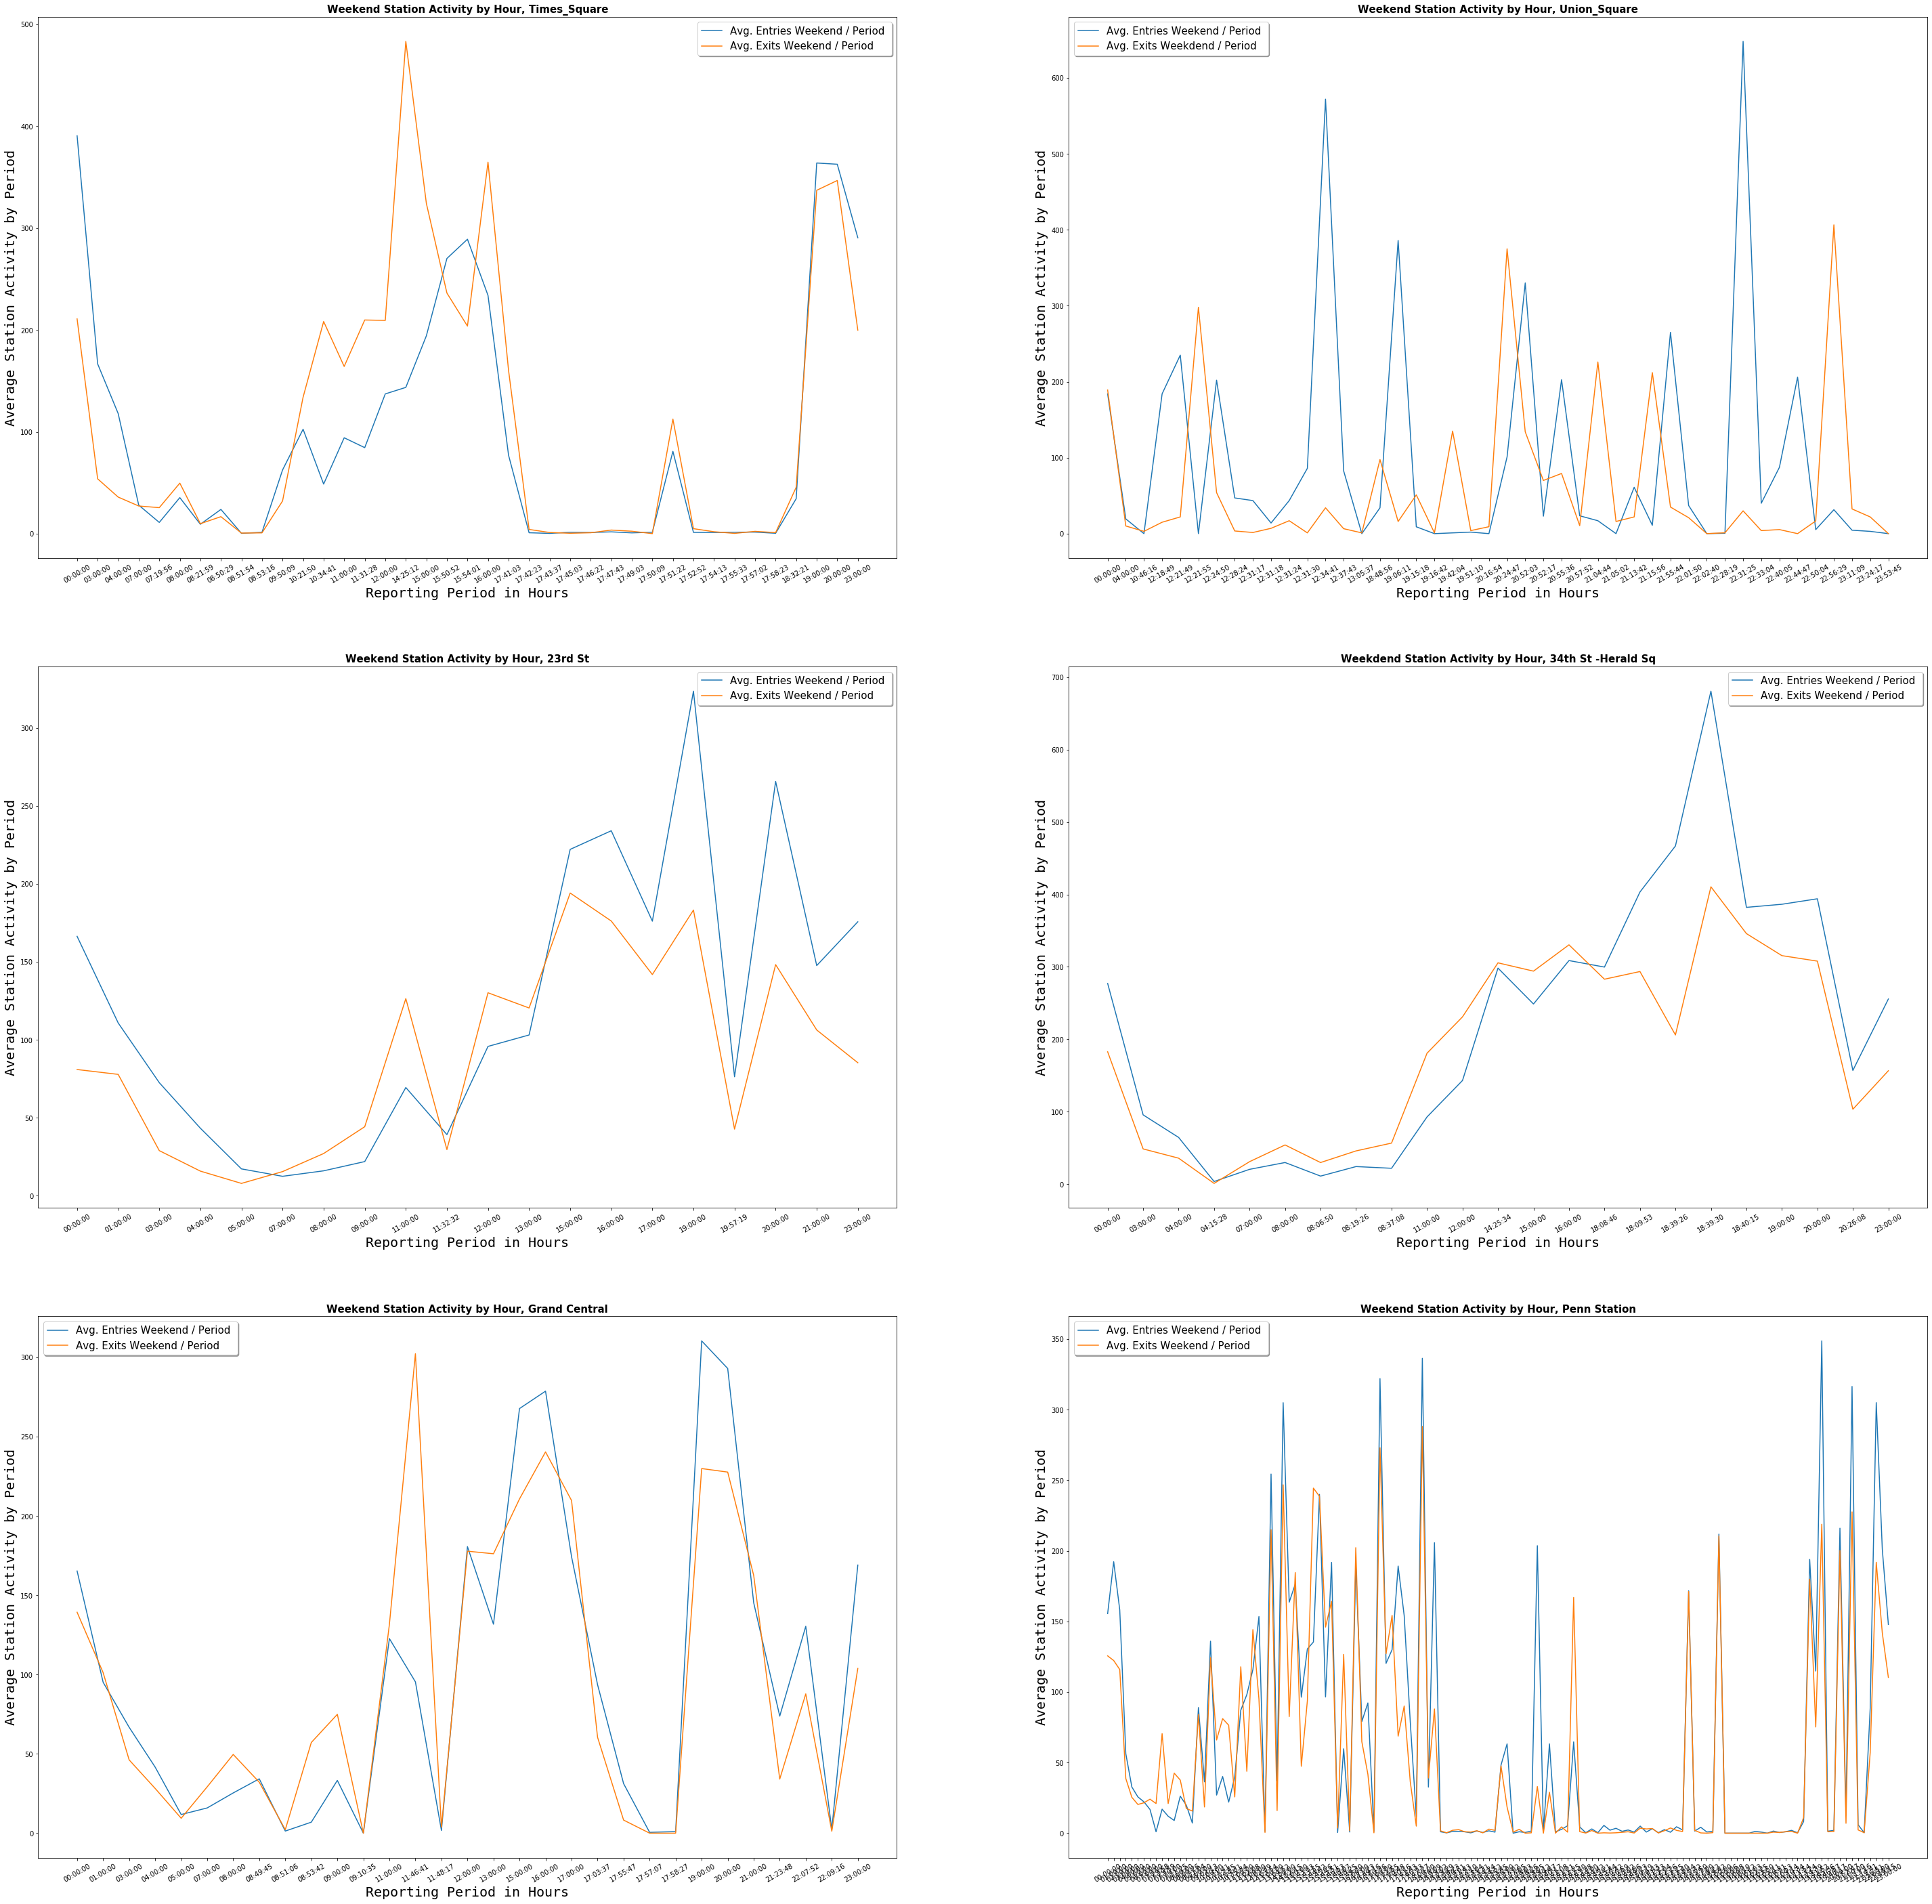

In [306]:
fig.set_figwidth(10)
fig.set_figheight(6)


plt.figure(figsize = [50, 50])

fig.suptitle('Top 6 Performing Station - Weekend',fontsize = 16)

plt.subplot(3,2,1)
plt.plot(times_hourly_df_weekend['time'],times_hourly_df_weekend['entry_increments'])
plt.plot(times_hourly_df_weekend['time'],times_hourly_df_weekend['exit_increments'])
plt.title('Weekend Station Activity by Hour, Times_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '20', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '20', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekend / Period ','Avg. Exits Weekend / Period '],shadow = True, loc = 0, prop={'size': 15})


plt.subplot(3,2,2)
plt.plot(union_hourly_df_weekend['time'],union_hourly_df_weekend['entry_increments'])
plt.plot(union_hourly_df_weekend['time'],union_hourly_df_weekend['exit_increments'])
plt.title('Weekend Station Activity by Hour, Union_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '20', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '20', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekend / Period ','Avg. Exits Weekdend / Period '],shadow = True, loc = 0, prop={'size': 15})

plt.subplot(3,2,3)
plt.plot(twentythird_hourly_df_weekend['time'],twentythird_hourly_df_weekend['entry_increments'])
plt.plot(twentythird_hourly_df_weekend['time'],twentythird_hourly_df_weekend['exit_increments'])
plt.title('Weekend Station Activity by Hour, 23rd St', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '20', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '20', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekend / Period ','Avg. Exits Weekend / Period '],shadow = True, loc = 0, prop={'size': 15})


plt.subplot(3,2,4)
plt.plot(herald_hourly_df_weekend['time'],herald_hourly_df_weekend['entry_increments'])
plt.plot(herald_hourly_df_weekend['time'],herald_hourly_df_weekend['exit_increments'])
plt.title('Weekdend Station Activity by Hour, 34th St -Herald Sq', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '20', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '20', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekend / Period ','Avg. Exits Weekend / Period '],shadow = True, loc = 0, prop={'size': 15})


plt.subplot(3,2,5)
plt.plot(grand_hourly_df_weekend['time'],grand_hourly_df_weekend['entry_increments'])
plt.plot(grand_hourly_df_weekend['time'],grand_hourly_df_weekend['exit_increments'])
plt.title('Weekend Station Activity by Hour, Grand Central', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '20', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '20', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekend / Period ','Avg. Exits Weekend / Period '],shadow = True, loc = 0, prop={'size': 15})

plt.subplot(3,2,6)
plt.plot(penn_hourly_df_weekend['time'],penn_hourly_df_weekend['entry_increments'])
plt.plot(penn_hourly_df_weekend['time'],penn_hourly_df_weekend['exit_increments'])
plt.title('Weekend Station Activity by Hour, Penn Station', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Average Station Activity by Period", fontsize = '20', family = 'monospace',color='black');
plt.xlabel("Reporting Period in Hours", fontsize = '20', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries Weekend / Period ','Avg. Exits Weekend / Period '],shadow = True, loc = 0, prop={'size': 15})

plt.savefig('top_stations_by_hour_weeekend.png');

In [309]:
timeblock_groupby = df.groupby('station','time_block')['entry_increments','exit_increments'].mean().reset_index()

timeblock_groupby_mask = (timeblock_groupby['station'] == '34 ST-PENN STA') | (
    timeblock_groupby['station'] == 'GRD CNTRL-42 ST') | (timeblock_groupby['station'] == '34 ST-HERALD SQ') | (
    timeblock_groupby['station'] == '23 ST') | (timeblock_groupby['station'] == '14 ST-UNION SQ') | (
    timeblock_groupby['station'] == 'TIMES SQ-42 ST')

timeblock_top_stations = timeblock_groupby[timeblock_groupby_mask]

timeblock_top_stations

ValueError: No axis named time_block for object type <class 'type'>

In [220]:
time_weekday_groupby = df.groupby(by = ['time_block','weekday']).mean()
time_weekday_groupby
# time_weekday_groupby_mask = 


# timeblock_groupby = df.groupby('time_block')['entry_increments','exit_increments'].mean().reset_index()

# timeblock_groupby_mask = (timeblock_groupby['station'] == '34 ST-PENN STA') | (
#     timeblock_groupby['station'] == 'GRD CNTRL-42 ST') | (timeblock_groupby['station'] == '34 ST-HERALD SQ') | (
#     timeblock_groupby['station'] == '23 ST') | (timeblock_groupby['station'] == '14 ST-UNION SQ') | (
#     timeblock_groupby['station'] == 'TIMES SQ-42 ST')

# timeblock_top_stations = timeblock_groupby[timeblock_groupby_mask]

# timeblock_top_stations

entries         exits  exit_increments  \
time_block weekday                                                  
0          Saturday   6.497825e+06  2.331592e+06         1.375000   
1          Saturday   2.941455e+07  2.169604e+07        27.953311   
2          Saturday   2.855805e+07  2.063549e+07        39.346756   
3          Saturday   2.834857e+07  2.088620e+07       111.316514   
4          Saturday   2.867617e+07  2.108077e+07       153.594227   
5          Saturday   2.863707e+07  2.105497e+07       155.251461   
6          Saturday   2.763704e+07  1.834791e+07        96.241245   
           Sunday     2.826254e+07  2.110184e+07        99.034735   
7          Sunday     2.898701e+07  2.143387e+07        28.004386   
8          Sunday     2.851680e+07  2.077405e+07        25.644050   
9          Sunday     2.817362e+07  2.059195e+07        87.990785   
10         Sunday     2.831359e+07  2.065643e+07       132.071518   
11         Sunday     2.846678e+07  2.038653e+07       127.690361   
12         Monday     2.919256e+07  2.144249e+07        70.407246   
           Sunday     1.902806e+07  1.266458e+07        80.810667   
13         Monday     2.869897e+07  2.088903e+07        15.803107   
14         Monday     2.823711e+07  2.031708e+07       114.925418   
15         Monday     2.816482e+07  2.025388e+07       238.932540   
16         Monday     2.767441e+07  2.003164e+07       175.083852   
17         Monday     2.783254e+07  2.014024e+07       270.351515   
18         Monday     1.829511e+07  1.215962e+07       136.074550   
           Tuesday    2.884699e+07  2.080009e+07        81.059264   
19         Tuesday    2.859587e+07  2.044696e+07        15.805005   
20         Tuesday    2.784121e+07  2.012487e+07       124.499382   
21         Tuesday    2.799243e+07  2.026655e+07       250.375288   
22         Tuesday    2.769283e+07  2.005717e+07       187.366729   
23         Tuesday    2.788986e+07  2.017966e+07       297.757017   
24         Tuesday    2.773108e+07  1.838670e+07       173.546875   
           Wednesday  2.801384e+07  2.019772e+07       107.129217   
25         Wednesday  2.871215e+07  2.079351e+07        18.346282   
26         Wednesday  2.911691e+07  2.048744e+07       128.621483   
27         Wednesday  2.874412e+07  2.075021e+07       226.436257   
28         Wednesday  2.792054e+07  2.024114e+07       194.723577   
29         Wednesday  2.811399e+07  2.021395e+07       295.295872   
30         Thursday   2.826769e+07  2.057741e+07       105.673287   
           Wednesday  2.325310e+07  1.541813e+07       184.091803   
31         Thursday   2.852841e+07  2.047294e+07        19.314322   
32         Thursday   2.811291e+07  2.019749e+07       123.518327   
33         Thursday   2.814006e+07  2.024368e+07       248.922498   
34         Thursday   2.831914e+07  2.042685e+07       186.059590   
35         Thursday   2.788709e+07  2.020490e+07       286.174375   
36         Friday     2.919127e+07  2.107926e+07       104.981714   
           Thursday   1.734183e+07  1.149903e+07       174.943765   
37         Friday     2.880339e+07  2.082920e+07        20.316186   
38         Friday     2.792178e+07  2.010316e+07       117.496685   
39         Friday     2.819627e+07  2.029722e+07       236.906329   
40         Friday     2.806858e+07  2.019720e+07       207.196417   
41         Friday     2.801054e+07  2.031411e+07       277.315149   
42         Friday     2.145308e+07  1.441262e+07       141.088957   

                      entry_increments  previous_entry_number  
time_block weekday                                             
0          Saturday           0.500000           6.497824e+06  
1          Saturday          23.604714           2.941453e+07  
2          Saturday          57.192990           2.855799e+07  
3          Saturday         137.876355           2.834843e+07  
4          Saturday         189.100188           2.867598e+07  
5          Saturday         182.335977           2.863689e+

In [228]:
# - silicon alley station -- mean entries and exits by time of day 

thritythird_mask = (hourly_groupby['station'] == '33 ST') ## - silicon Alley
thritythird_df = hourly_groupby[thritythird_mask]

twentyeight_mask = (hourly_groupby['station'] == '28 ST') ## - silicon Alley
twentyeight_df = hourly_groupby[twentyeight_mask]

twentythird_hourly_mask = (hourly_groupby['station'] == '23 ST') ## - silicon Alley
twentythird_hourly_df = hourly_groupby[twentythird_hourly_mask]

hourly_groupby.head()


,station,time,entry_increments,exit_increments
0,1 AV,00:00:00,200.883333,200.750000
1,145 ST,00:00:00,128.016807,296.957983
2,GRANT AV,00:00:00,72.333333,220.083333
3,BEACH 67 ST,00:00:00,30.633333,59.733333
4,MARBLE HILL-225,00:00:00,70.133333,29.400000


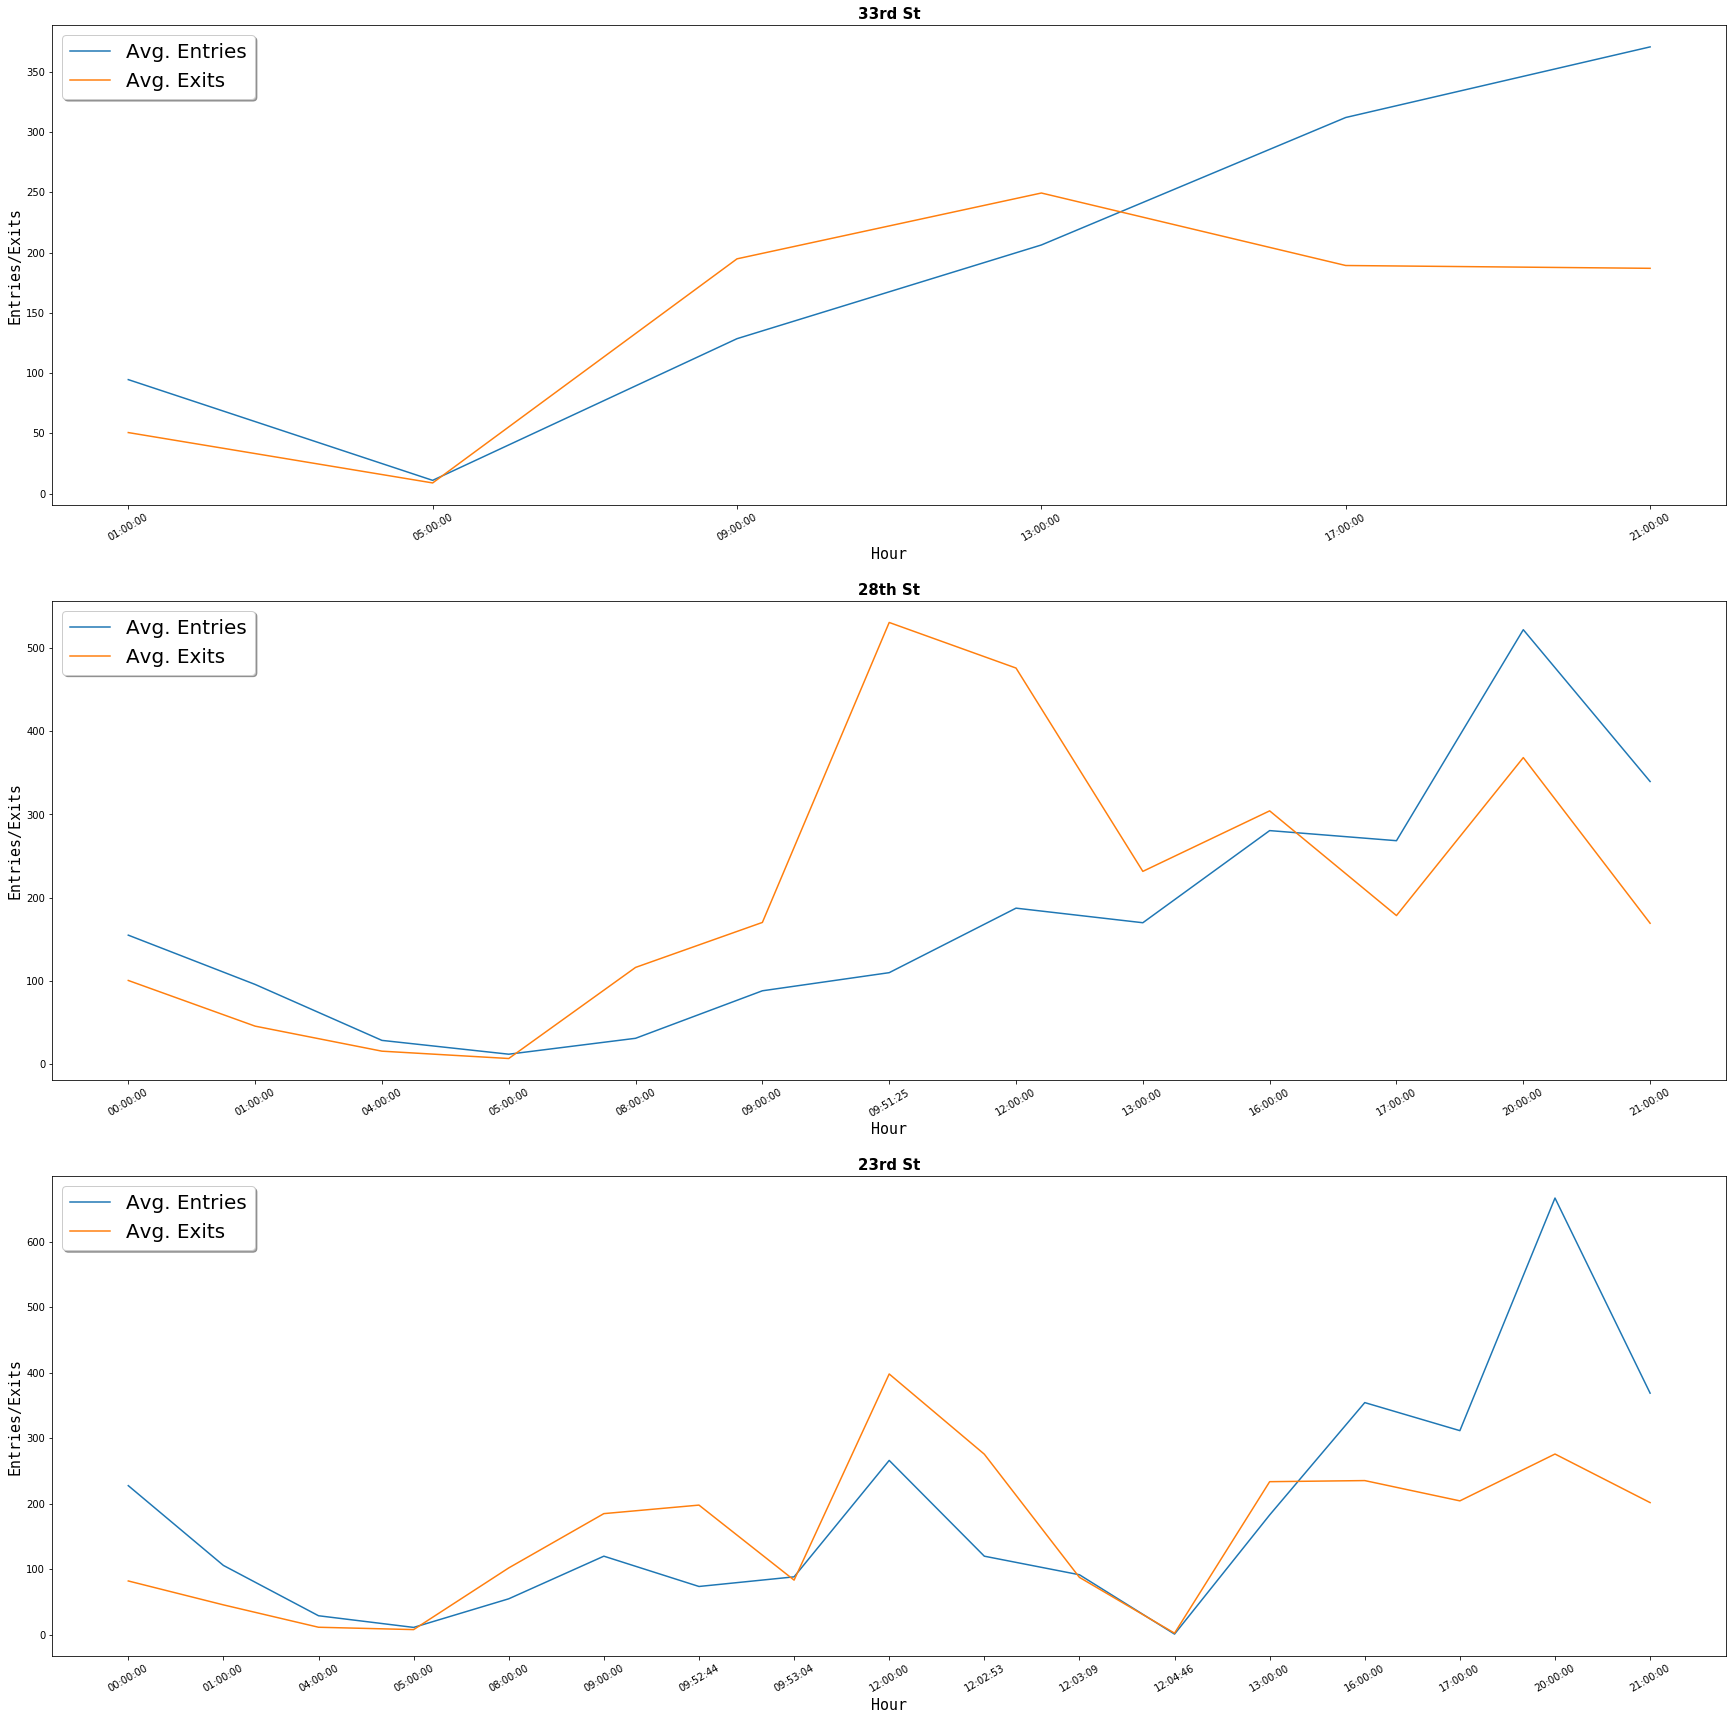

In [237]:
fig.set_figwidth(10)
fig.set_figheight(6)


plt.figure(figsize = [30, 30])
fig.suptitle('Silicon Alley Stations Avg. Entrances/Exits',fontsize = 16)

plt.subplot(3,1,1)
plt.plot(thritythird_df['time'],thritythird_df['entry_increments'])
plt.plot(thritythird_df['time'],thritythird_df['exit_increments'])
plt.title('33rd St', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries','Avg. Exits'],shadow = True, loc = 0, prop={'size': 20})




plt.subplot(3,1,2)
plt.plot(twentyeight_df['time'],twentyeight_df['entry_increments'])
plt.plot(twentyeight_df['time'],twentyeight_df['exit_increments'])
plt.title('28th St', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries','Avg. Exits'],shadow = True, loc = 0, prop={'size': 20})



plt.subplot(3,1,3)
plt.plot(twentythird_hourly_df['time'],twentythird_hourly_df['entry_increments'])
plt.plot(twentythird_hourly_df['time'],twentythird_hourly_df['exit_increments'])
plt.title('23rd St', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)
plt.legend(['Avg. Entries','Avg. Exits'],shadow = True, loc = 0, prop={'size': 20})

plt.savefig('silicon_alley_stations_by_hour.png');